In [304]:
import warnings
warnings.simplefilter(action='ignore')

In [305]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PowerTransformer, QuantileTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from statsmodels.stats.outliers_influence import variance_inflation_factor
from skopt import BayesSearchCV

In [306]:
RANDOM_STATE=177013

## Data review

In [307]:
df = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv', index_col='id')

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

In [309]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loading,26320.0,127.826233,39.030020,33.160,99.98750,122.3900,149.15250,385.860
attribute_2,26570.0,6.754046,1.471852,5.000,6.00000,6.0000,8.00000,9.000
attribute_3,26570.0,7.240459,1.456493,5.000,6.00000,8.0000,8.00000,9.000
measurement_0,26570.0,7.415883,4.116690,0.000,4.00000,7.0000,10.00000,29.000
measurement_1,26570.0,8.232518,4.199401,0.000,5.00000,8.0000,11.00000,29.000
measurement_2,26570.0,6.256568,3.309109,0.000,4.00000,6.0000,8.00000,24.000
measurement_3,26189.0,17.791528,1.001200,13.968,17.11700,17.7870,18.46900,21.499
measurement_4,26032.0,11.731988,0.996085,8.008,11.05100,11.7330,12.41000,16.484
measurement_5,25894.0,17.127804,0.996414,12.073,16.44300,17.1320,17.80500,21.425
measurement_6,25774.0,17.510759,0.995980,12.715,16.83900,17.5160,18.17800,21.543


In [310]:
df.isna().mean()

product_code      0.000000
loading           0.009409
attribute_0       0.000000
attribute_1       0.000000
attribute_2       0.000000
attribute_3       0.000000
measurement_0     0.000000
measurement_1     0.000000
measurement_2     0.000000
measurement_3     0.014339
measurement_4     0.020248
measurement_5     0.025442
measurement_6     0.029959
measurement_7     0.035265
measurement_8     0.039443
measurement_9     0.046180
measurement_10    0.048927
measurement_11    0.055250
measurement_12    0.060256
measurement_13    0.066767
measurement_14    0.070531
measurement_15    0.075612
measurement_16    0.079413
measurement_17    0.085962
failure           0.000000
dtype: float64

In [311]:
df['product_code'].value_counts()

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

In [312]:
df['attribute_0'].value_counts()

material_7    21320
material_5     5250
Name: attribute_0, dtype: int64

In [313]:
df['attribute_1'].value_counts()

material_8    10865
material_5    10362
material_6     5343
Name: attribute_1, dtype: int64

In [314]:
df['attribute_2'].value_counts()

6    10455
5     5765
8     5250
9     5100
Name: attribute_2, dtype: int64

In [315]:
df['attribute_3'].value_counts()

8    11015
9     5343
6     5112
5     5100
Name: attribute_3, dtype: int64

In [316]:
df['failure'].value_counts()

0    20921
1     5649
Name: failure, dtype: int64

## Preprocessing

Tried various methods of imputation and encoding but without much effect. So, OHE, median and TruncatedSVD:

In [317]:
def fill_with_median(df, columns):
    for column in columns:
        df[column] = df[column].fillna(df[column].median())
    return df

In [318]:
def one_hot_encoding(df, columns):
    dummies = pd.get_dummies(df[columns], drop_first=True)
    df[dummies.columns] = dummies
    return df

In [319]:
def drop_unused_columns (df, column_list):
    return df.drop (column_list, axis=1)

In [320]:
encoded_columns = list(df.filter(like='attribute').columns)
encoded_columns.append('product_code')
encoded_columns

['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'product_code']

In [322]:
columns_to_compress = list(df.filter(like='measurement').columns)

In [321]:
df = (
        df.pipe(fill_with_median, columns_to_compress + ['loading'])
        .pipe(one_hot_encoding, encoded_columns)
        .pipe(drop_unused_columns, encoded_columns)
    )

In [323]:
N_COMPONENTS = 3

This is in fact very questionable since measurement scaling varies, and it's not even guaranteed to be helpful for classification. Works well on public test though.

In [324]:
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
#svd = LinearDiscriminantAnalysis(n_components=1)
svd.fit(df[columns_to_compress], df['failure'])
svd.explained_variance_ratio_.sum()

0.996971181752584

In [325]:
#svd_headers = 'lda'
svd_headers = ['svd' + str(i) for i in range(1, N_COMPONENTS + 1)]
df[svd_headers] = svd.transform(df[columns_to_compress])
df = df.drop(columns_to_compress, axis=1)

In [326]:
df_check = df.dropna()
features_train = df_check.drop(['failure'], axis=1)
target_train = df_check['failure']

## Feature selection

TL;DR: most are useless. Loading and 2/3 of SVD left in.

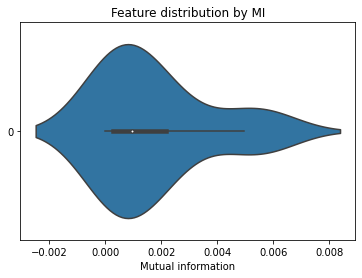

In [327]:
mi_scores = mutual_info_classif(features_train, target_train, random_state=RANDOM_STATE)
sns.violinplot(data=mi_scores, orient='h').set(title='Feature distribution by MI', xlabel='Mutual information');

In [328]:
mic_data = pd.DataFrame()
mic_data['feature'] = features_train.columns
mic_data['MIC'] = mi_scores
  
mic_data.sort_values(by='MIC', ascending=False)

,feature,MIC
1,attribute_0_material_7,0.005908
0,loading,0.004956
7,product_code_E,0.002561
4,product_code_B,0.001774
6,product_code_D,0.001450
9,svd2,0.000957
10,svd3,0.000953
5,product_code_C,0.000581
2,attribute_1_material_6,0.000000
3,attribute_1_material_8,0.000000


In [329]:
recommended_columns = set(mic_data[mic_data['MIC'] != 0]['feature'])

In [330]:
recommended_columns= list(recommended_columns.difference(set(['attribute_1_material_6', 'attribute_0_material_7', 'attribute_1_material_8','product_code_E', 'product_code_D', 'product_code_B', 'product_code_C'])))

In [331]:
vif_data = pd.DataFrame()
vif_data['feature'] = features_train[recommended_columns].columns
vif_data['VIF'] = [variance_inflation_factor(features_train[recommended_columns].values, i) for i in range(len(features_train[recommended_columns].columns))]
  
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
0,loading,1.024747
1,svd2,1.024747
2,svd3,1.000000


In [332]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(features_train[recommended_columns])
X_train_std_sm = sm.add_constant(X_train_std)
log_reg = sm.Logit(target_train, X_train_std_sm).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.508896
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                failure   No. Observations:                26570
Model:                          Logit   Df Residuals:                    26566
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Aug 2022   Pseudo R-squ.:                 0.01642
Time:                        12:45:26   Log-Likelihood:                -13521.
converged:                       True   LL-Null:                       -13747.
Covariance Type:            nonrobust   LLR p-value:                 1.584e-97
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3358      0.015    -87.183      0.000      -1.366      -1.306
x1             0.2972      0.014     20.657      0.000       0.269       0.325
x2             0.0777      0.015      5.130      0.000       0.048       0.107
x3             0.0300      0.015      1.985      0.047       0.000       0.060
==============================================================================
"""

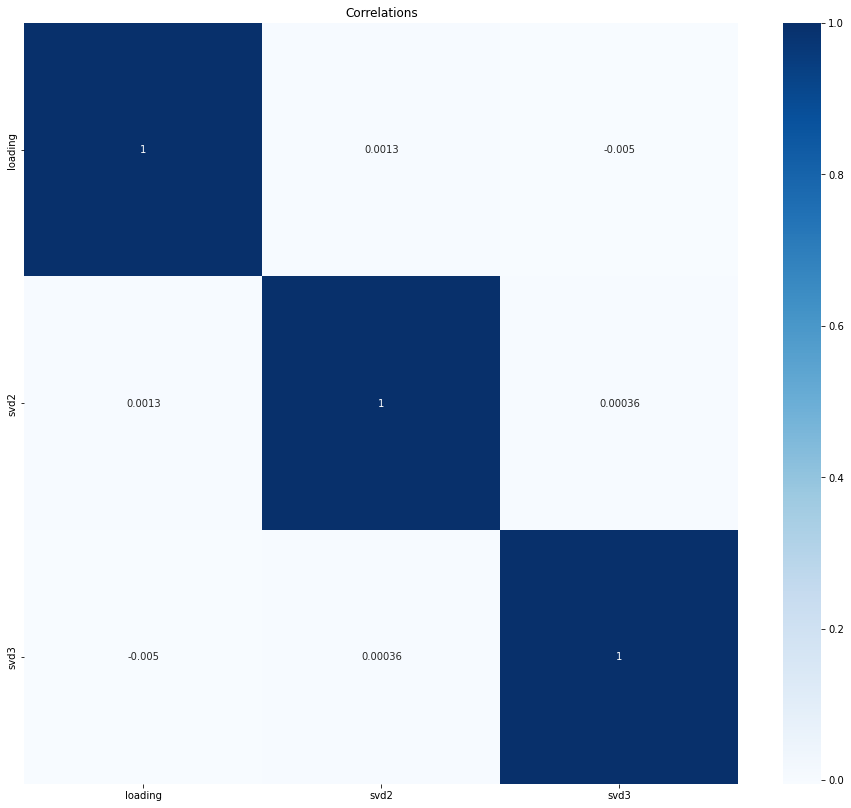

In [333]:
plt.figure(figsize=(16,14))
sns.heatmap(features_train[recommended_columns].corr(), annot=True, cmap='Blues').set(title='Correlations');

## Splitting

In [334]:
df_clean = df[recommended_columns+['failure']]

In [335]:
df_features = df_clean.drop(['failure'], axis=1)
df_target = df_clean['failure']
#features_train = df_features
#target_train = df_target

In [336]:
features_train, features_test, target_train, target_test = train_test_split(df_features, df_target, test_size=0.1, random_state=RANDOM_STATE)

## Baseline

In [337]:
for strategy in ['most_frequent', 'prior', 'stratified', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(features_train, target_train)
    dummy_predictions = dummy.predict(features_test)
       
    f1 = f1_score(target_test, dummy_predictions)
    acc = accuracy_score(target_test, dummy_predictions)
    roc_auc = roc_auc_score(target_test, dummy_predictions)
    
    print(f'Strategy: {strategy}, F1: {f1:.1f}, ROC_AUC: {roc_auc:.1f}, accuracy: {acc:.1f}')

Strategy: most_frequent, F1: 0.0, ROC_AUC: 0.5, accuracy: 0.8
Strategy: prior, F1: 0.0, ROC_AUC: 0.5, accuracy: 0.8
Strategy: stratified, F1: 0.2, ROC_AUC: 0.5, accuracy: 0.7
Strategy: uniform, F1: 0.3, ROC_AUC: 0.5, accuracy: 0.5


## Optimization

In [338]:
scaler_list = [Normalizer(),
               MinMaxScaler(),
               StandardScaler(),
               RobustScaler(),
               PowerTransformer(),
               QuantileTransformer(random_state=RANDOM_STATE),
               QuantileTransformer(random_state=RANDOM_STATE, output_distribution='normal')]

Worth noting optimizing for ROC_AUC yields a bit worse result - things may change on a full test though.

In [339]:
def optimize(model, params, X, y):
    name = f'{type(model).__name__}'
    print(f'Optimizing {name}...')
    pipe = Pipeline([('scaler', StandardScaler()), ('classifier', model)]) 
    gcv = BayesSearchCV(pipe, search_spaces=params, cv=5, scoring='f1', random_state=RANDOM_STATE, n_jobs=-1)
    gcv.fit(X, y)
    print(f'Best params: {dict(gcv.best_params_)}')
    print(f'F1: {(gcv.best_score_):.2f}')
    return gcv.best_estimator_

In [340]:
%%time
linear_params = {
                    'scaler': scaler_list,
                    'classifier__fit_intercept':[True, False],
                    #'classifier__l1_ratio':[0, 0.5, 1],
                    #'classifier__class_weight':[None, 'balanced'],
                }
best_linear = optimize(LogisticRegression(n_jobs=-1, random_state=RANDOM_STATE, penalty='none'), linear_params, features_train, target_train)

Optimizing LogisticRegression...
Best params: {'classifier__fit_intercept': False, 'scaler': PowerTransformer()}
F1: 0.36
CPU times: user 2min 36s, sys: 2min 1s, total: 4min 37s
Wall time: 1min 51s


In [341]:
%%time
nb_params = {
                    'scaler': scaler_list,
                }
best_nb = optimize(GaussianNB(), nb_params, features_train, target_train)

Optimizing GaussianNB...
Best params: {'scaler': MinMaxScaler()}
F1: 0.05
CPU times: user 1min 58s, sys: 1min 40s, total: 3min 38s
Wall time: 1min 7s


In [342]:
%%time
sgd_params = {
                    'scaler': scaler_list,
                    'classifier__fit_intercept':[True, False],
                    'classifier__shuffle':[True, False],
                    'classifier__loss':['log','modified_huber']
                }
best_sgd = optimize(SGDClassifier(random_state=RANDOM_STATE, n_jobs=-1), sgd_params, features_train, target_train)

Optimizing SGDClassifier...
Best params: {'classifier__fit_intercept': False, 'classifier__loss': 'log', 'classifier__shuffle': True, 'scaler': PowerTransformer()}
F1: 0.35
CPU times: user 3min 18s, sys: 2min 23s, total: 5min 41s
Wall time: 2min 14s


## Evaluation

In [343]:
def calculate_metrics(probabilities, target_test):
    predictions = (probabilities > 0.5)
    f1 = f1_score(target_test, predictions)
    roc_auc = roc_auc_score(target_test, probabilities)
    acc = accuracy_score(target_test, predictions)
    ap = average_precision_score(target_test, probabilities)
    cmatrix = confusion_matrix(target_test, predictions)
    
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)
    best_f1 = np.max(f1_scores)
    best_thresh = thresholds[np.argmax(f1_scores)]

    pred_t = (probabilities > best_thresh)
    best_cmatrix = confusion_matrix(target_test, pred_t)
    
    return f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

def visualize_tests(probabilities, target_test):
    cmatrices = []

    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    print('Processing validation set, please wait warmly...')
    f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics (probabilities, target_test)
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);
    print (f'F1: {f1:.2f} (max: {best_f1:.2f} at {best_thresh:.2f} threshold), ROC_AUC: {roc_auc:.3f}, accuracy: {acc:.0%}, AP (PR_AUC): {ap:.2f}')
    cmatrices.append(cmatrix)
    cmatrices.append(best_cmatrix)
    
    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC curve', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR curve', xlim=(0,1), ylim=(0,1))
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
    for cmatrix, ax, title in zip(cmatrices, axes.flat, ['Confusion Maxtrix', 'Confusion Maxtrix (optimal F1 threshold)']):
        sns.heatmap(cmatrix, ax=ax, annot=True, cmap='Blues', fmt='d').set(title=title, xlabel='Prediction', ylabel='Reality')
    
    return best_thresh

Processing validation set, please wait warmly...
F1: 0.34 (max: 0.35 at 0.50 threshold), ROC_AUC: 0.602, accuracy: 55%, AP (PR_AUC): 0.26


0.5049684477601508

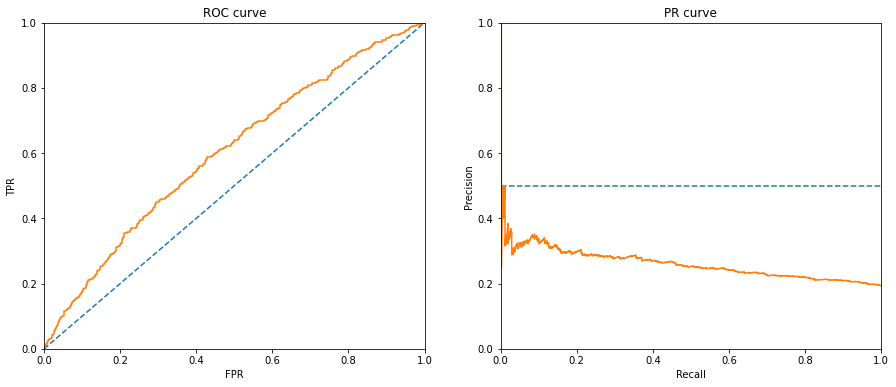

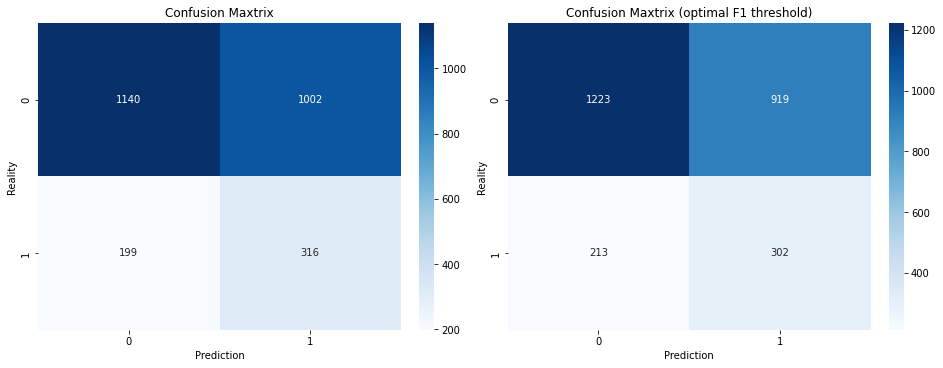

In [344]:
probs0 = best_linear.predict_proba(features_test)[:,1]
visualize_tests(probs0, target_test)

Processing validation set, please wait warmly...
F1: 0.07 (max: 0.34 at 0.19 threshold), ROC_AUC: 0.596, accuracy: 80%, AP (PR_AUC): 0.26


0.18577973859079766

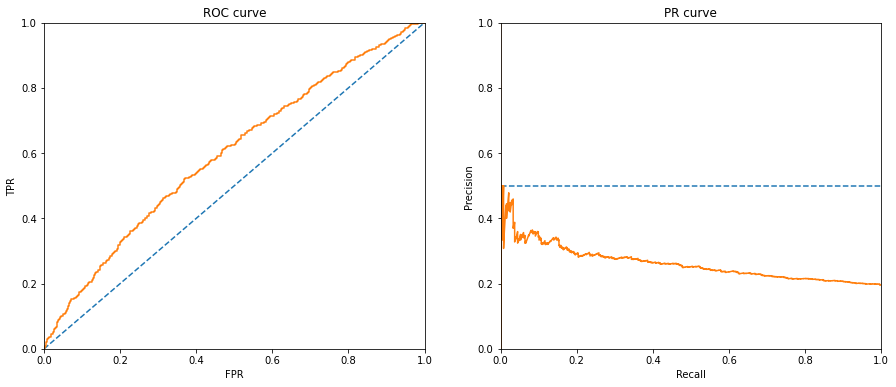

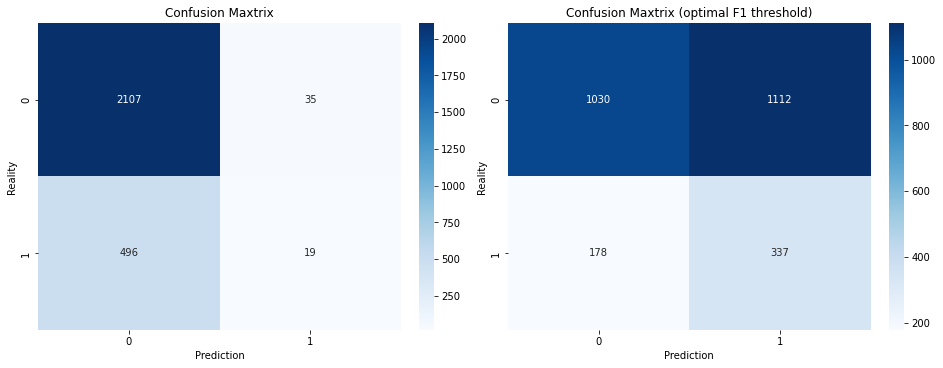

In [345]:
probs1 = best_nb.predict_proba(features_test)[:,1]
visualize_tests(probs1, target_test)

Processing validation set, please wait warmly...
F1: 0.34 (max: 0.35 at 0.50 threshold), ROC_AUC: 0.590, accuracy: 55%, AP (PR_AUC): 0.25


0.5002801428951411

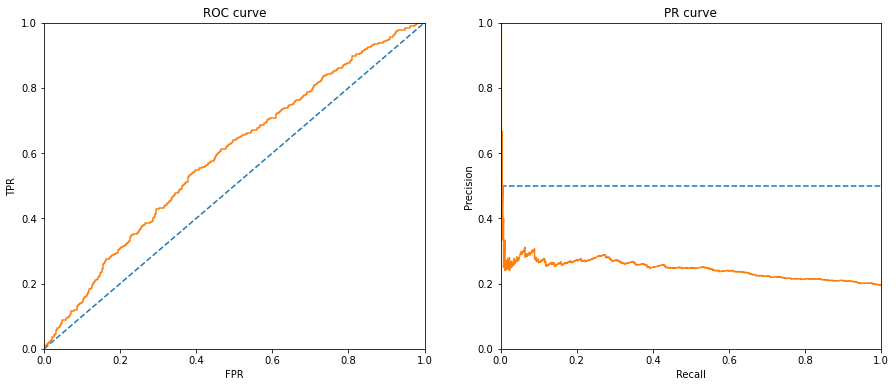

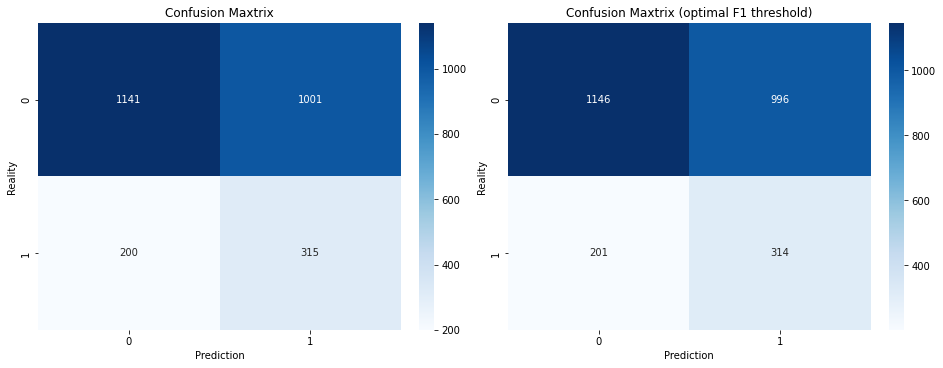

In [346]:
probs2 = best_sgd.predict_proba(features_test)[:,1]
visualize_tests(probs2, target_test)

## Ensembling

In [347]:
vote = VotingClassifier(estimators=[('lr', best_linear), ('nb', best_nb), ('sgd', best_sgd)], n_jobs=-1, voting='soft')

In [348]:
stack = StackingClassifier(estimators=[('lr', best_linear), ('sgd', best_sgd)], final_estimator=LogisticRegression(), cv=5, n_jobs=-1)

Processing validation set, please wait warmly...
F1: 0.18 (max: 0.35 at 0.39 threshold), ROC_AUC: 0.600, accuracy: 78%, AP (PR_AUC): 0.26


0.38683011103100434

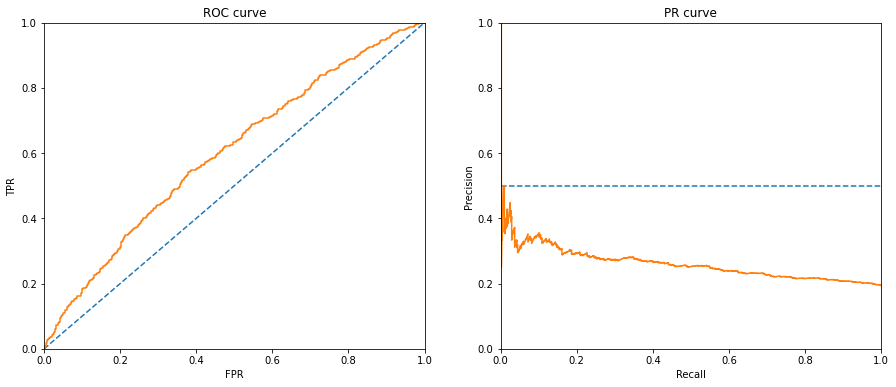

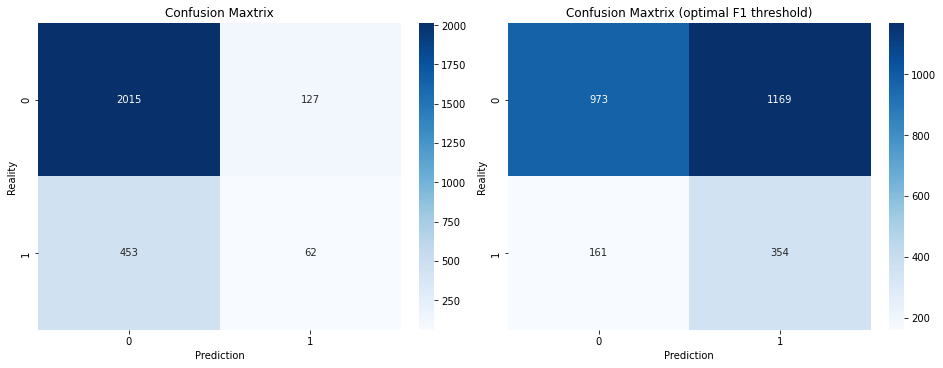

In [349]:
vote.fit(features_train, target_train)
probs3 = vote.predict_proba(features_test)[:,1]
visualize_tests(probs3, target_test)

Processing validation set, please wait warmly...
F1: 0.00 (max: 0.35 at 0.21 threshold), ROC_AUC: 0.602, accuracy: 81%, AP (PR_AUC): 0.26


0.2097251806103405

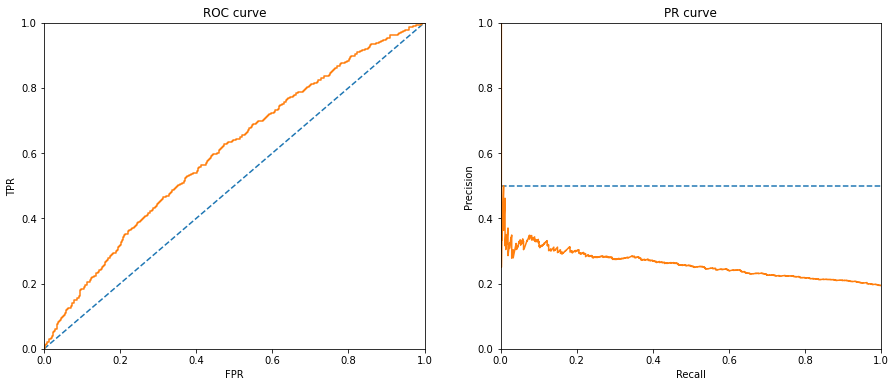

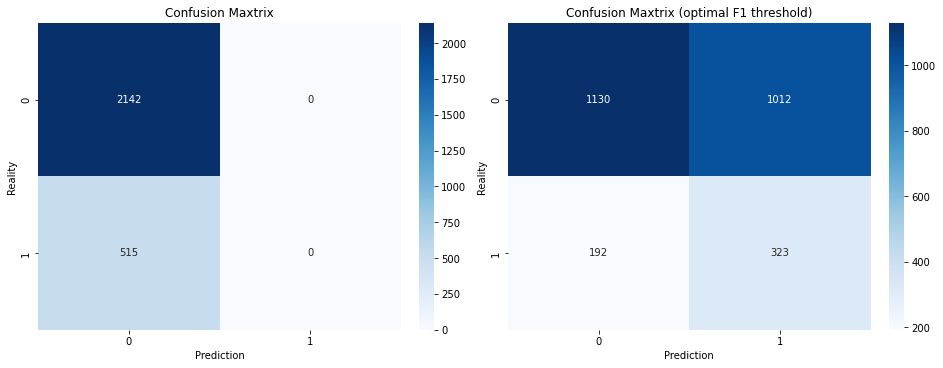

In [350]:
stack.fit(features_train, target_train)
probs4 = stack.predict_proba(features_test)[:,1]
visualize_tests(probs4, target_test)

## Testing

In [351]:
df2 = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv', index_col='id')

In [352]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20775 entries, 26570 to 47344
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    20775 non-null  object 
 1   loading         20552 non-null  float64
 2   attribute_0     20775 non-null  object 
 3   attribute_1     20775 non-null  object 
 4   attribute_2     20775 non-null  int64  
 5   attribute_3     20775 non-null  int64  
 6   measurement_0   20775 non-null  int64  
 7   measurement_1   20775 non-null  int64  
 8   measurement_2   20775 non-null  int64  
 9   measurement_3   20446 non-null  float64
 10  measurement_4   20366 non-null  float64
 11  measurement_5   20267 non-null  float64
 12  measurement_6   20151 non-null  float64
 13  measurement_7   20055 non-null  float64
 14  measurement_8   19929 non-null  float64
 15  measurement_9   19871 non-null  float64
 16  measurement_10  19708 non-null  float64
 17  measurement_11  19639 non-n

In [353]:
df2 = (
        df2.pipe(fill_with_median, columns_to_compress + ['loading'])
        .pipe(one_hot_encoding, encoded_columns)
        .pipe(drop_unused_columns, encoded_columns)
    )

In [354]:
df2[svd_headers] = svd.transform(df2[columns_to_compress])
df2 = df2.drop(columns_to_compress, axis=1)

In [355]:
result = stack.predict_proba(df2[recommended_columns])

In [356]:
test_results = pd.DataFrame(data = {'id': df2.index, 'failure': result[:,1]}).set_index('id')

In [357]:
test_results

,failure
id,
26570,0.197952
26571,0.185678
26572,0.190300
26573,0.185369
26574,0.316530
...,...
47340,0.236225
47341,0.135502
47342,0.137812


In [358]:
test_results.to_csv('submission.csv')

This yields 0.58785 ROC_AUC on the public test, which can be improved a bit further by fitting whe whole dataset.